# Calibration of spectra
`author` Julien Morin <julien.morin@umontpellier.fr>

`date` 28 Aug 2022

Adapted from HAP703P

References: *Handbook of CCD Astronomy* §6 ; *Handbook of Astronomical Spectroscopy* §6
* flat field correction of stellar and calibration spectra
* wavelength calibration of stellar spectra
* save spectra as FITS files

In [1]:
# import and settings
%matplotlib notebook
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import astropy.io.fits as pf
from astropy.modeling import models
from astropy.stats import mad_std
from astropy.table import QTable
from astropy import units as u
import pydis_um 
from astroplan.plots import plot_finder_image
from astroplan import FixedTarget
from astropy.visualization import ZScaleInterval
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
from astroplan import FixedTarget, Observer
from astropy.nddata import StdDevUncertainty
from pytz import timezone
import ccdproc as ccdp
from specutils.manipulation import LinearInterpolatedResampler
import specutils
import specutils.fitting as spf
from specutils.manipulation import extract_region
from specutils import Spectrum1D, SpectralRegion
from iraf_um import imstat

## Load previously computed data 

In [2]:
# define CCD characteristics
ccd_gain = 0.9209873080253601 * u.electron / u.adu
ccd_ron = 2.6899022348084642 * u.electron

In [3]:
# define file names
fname_sci = 'Master_M76_s1d.fit'
fname_rvstd = 'Master_ksi_Cas_s1d.fit'
# load spectra
sci_s1d = ccdp.CCDData.read('reduced/' + fname_sci)
rvstd_s1d = ccdp.CCDData.read('reduced/' + fname_rvstd)
mflat_s1d = ccdp.CCDData.read('reference/master_flat_s1d.fits')
mwcal_s1d = ccdp.CCDData.read('reference/master_wcal_s1d.fits')

## Normalise flat field and correct other frames

Fit RMS deviation = 0.104 e-


<IPython.core.display.Javascript object>


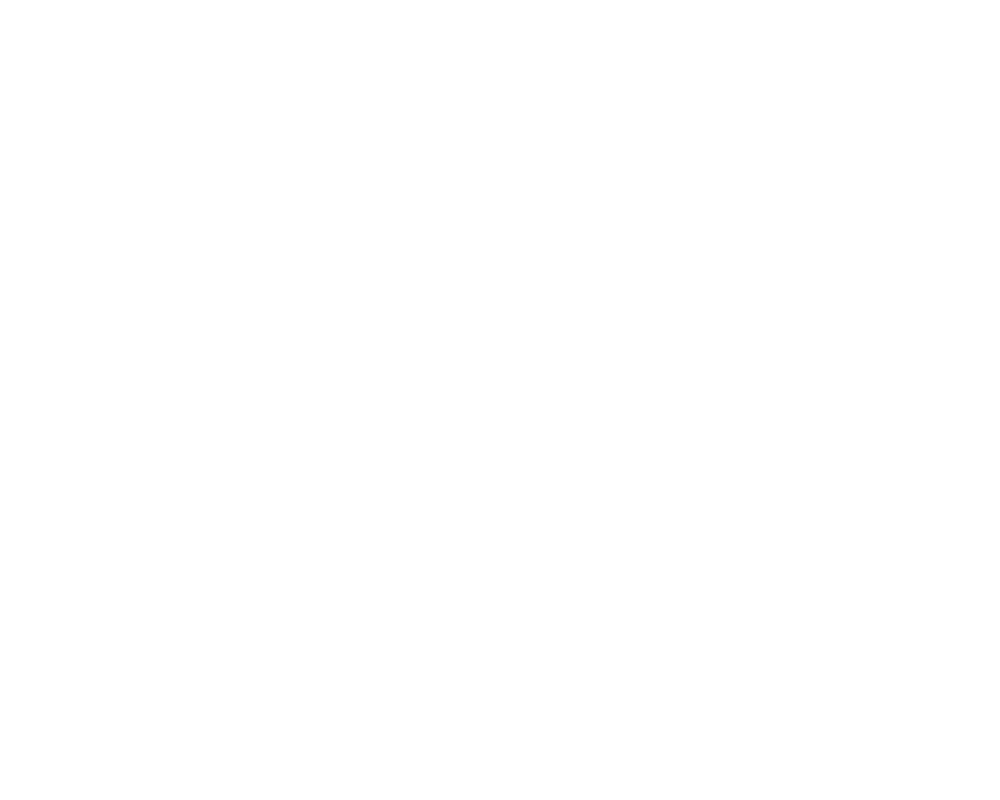

In [4]:
# normalise flat field to keep only small-scale variations
mflat_s1d_medfilt = sp.ndimage.median_filter(mflat_s1d.data, size=100)
x_ccd = np.linspace(0, mflat_s1d.data.shape[0],  mflat_s1d.data.shape[0])
mflat_coeff = np.polyfit(x_ccd, mflat_s1d.data, deg=4) #### MODIF Deg =3 -> Deg =4
mflat_fit = np.poly1d(mflat_coeff)(x_ccd)
mflat_n_s1d = mflat_s1d.data / mflat_fit
#
rms = np.sqrt(np.mean((mflat_fit - mflat_s1d.data)**2))
print("Fit RMS deviation = %.3f e-" % rms)

# plot fit and result
%matplotlib notebook
fig = plt.figure(figsize=(10,8))
#
ax1 = fig.add_subplot(211)
ax1.plot(mflat_s1d.data, c='tab:blue')
ax1.plot(mflat_fit, c='tab:orange')
ax1.axvline(850, ls='--', c='k', lw=0.4)
ax1.set_title('Master flat field and polynomial fit')
#
ax2 = fig.add_subplot(212)
ax2.plot(mflat_n_s1d, c='tab:green')
ax2.axvline(850, ls='--', c='k', lw=0.4)
ax2.set_title('normalised master flat field')
#
plt.show()

<IPython.core.display.Javascript object>


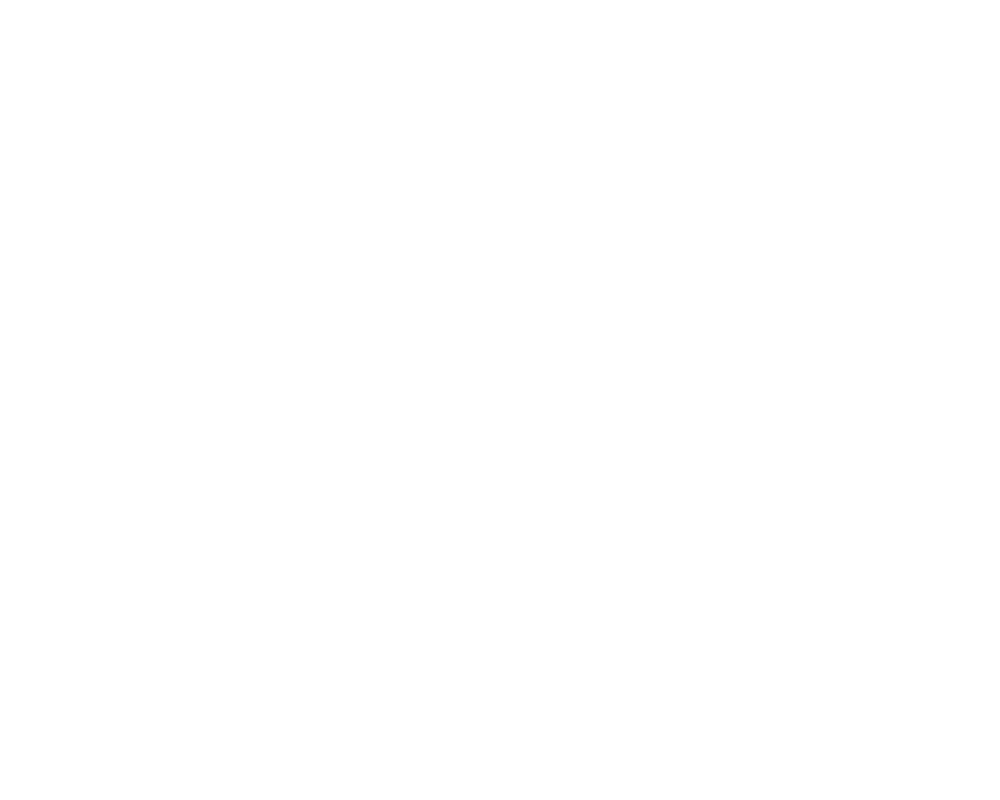

In [5]:
# apply flat field correction to science and rv std spectra
sci_f_s1d = sci_s1d.data / mflat_n_s1d
sig_sci_f_s1d = copy.deepcopy(sci_s1d.uncertainty)
#sig_sci_f_s1d /= mflat_n_s1d
#
rvstd_f_s1d = rvstd_s1d.data / mflat_n_s1d
sig_rvstd_f_s1d = copy.deepcopy(rvstd_s1d.uncertainty)
#sig_rvstd_f_s1d /= mflat_n_s1d


# plot fit and result
%matplotlib notebook
fig = plt.figure(figsize=(10,8))
#
ax1 = fig.add_subplot(211)
ax1.plot(sci_s1d.data, c='tab:blue')
ax1.plot(sci_f_s1d, c='tab:orange')
ax1.axvline(850, ls='--', c='k', lw=0.4)
ax1.set_title('Science spectrum before and after flat field correction')
#
ax2 = fig.add_subplot(212)
ax2.plot(rvstd_s1d.data, c='tab:blue')
ax2.plot(rvstd_f_s1d, c='tab:orange')
ax2.axvline(850, ls='--', c='k', lw=0.4)
ax2.set_title('RV Standard spectrum before and after flat field correction')
#
plt.show()

1022.47989200933


<IPython.core.display.Javascript object>


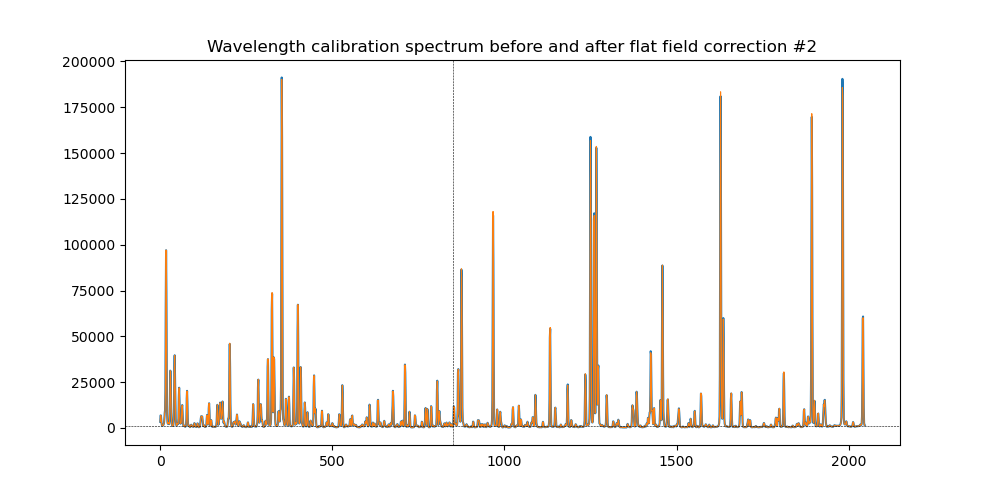

In [6]:
# apply flat field correction to wavelength calibration spectrum
## flat field normalised by polynomial fit
mwcal_f_s1d = mwcal_s1d.data / mflat_n_s1d
# compute baseline level
mwcal_base = np.median(mwcal_f_s1d[1100:])
print(mwcal_base)
# plot fit and result
%matplotlib notebook
fig = plt.figure(figsize=(10,5))
#
ax1 = fig.add_subplot(111)
ax1.plot(mwcal_s1d.data, c='tab:blue')
ax1.plot(mwcal_f_s1d, c='tab:orange', lw=.8)
ax1.axvline(850, ls='--', c='k', lw=0.4)
ax1.axhline(mwcal_base, ls='--', c='k', lw=0.4)
ax1.set_title('Wavelength calibration spectrum before and after flat field correction #2')
#
plt.show()
# remove baseline level from wcal frame
mwcal_f_s1d -= mwcal_base

## Wavelength calibration

In [7]:
# convert wcal spectrum to a specutils.Spectrum1D instance
mwcal_f_s1d = specutils.Spectrum1D(mwcal_f_s1d.data*u.adu)

41 emission lines identified
line_center line_type line_center_index
    pix                                
----------- --------- -----------------
       17.0  emission                17
       29.0  emission                29
       41.0  emission                41
       54.0  emission                54
      201.0  emission               201
      284.0  emission               284
      312.0  emission               312
      324.0  emission               324
      330.0  emission               330
      353.0  emission               353
        ...       ...               ...
     1425.0  emission              1425
     1459.0  emission              1459
     1571.0  emission              1571
     1628.0  emission              1628
     1636.0  emission              1636
     1689.0  emission              1689
     1811.0  emission              1811
     1893.0  emission              1893
     1982.0  emission              1982
     2041.0  emission              2041
Length = 41


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


<IPython.core.display.Javascript object>


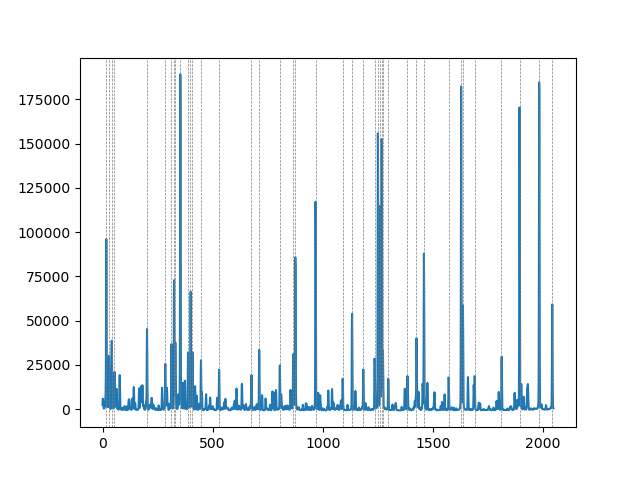

In [8]:
# detect spectral lines
#lines = spf.find_lines_derivative(mwcal_f_s1d, flux_threshold=1.e5)
lines = spf.find_lines_derivative(mwcal_f_s1d, flux_threshold=1.6e4)
lines[lines['line_type'] == 'emission']
print("%d emission lines identified" % len(lines))
print(lines)
# plot identified lines
plt.figure()
plt.plot(mwcal_f_s1d.flux)
for l in lines:
    plt.axvline(l['line_center_index'], ls='--', c='grey', lw=0.5)
plt.show()

<IPython.core.display.Javascript object>


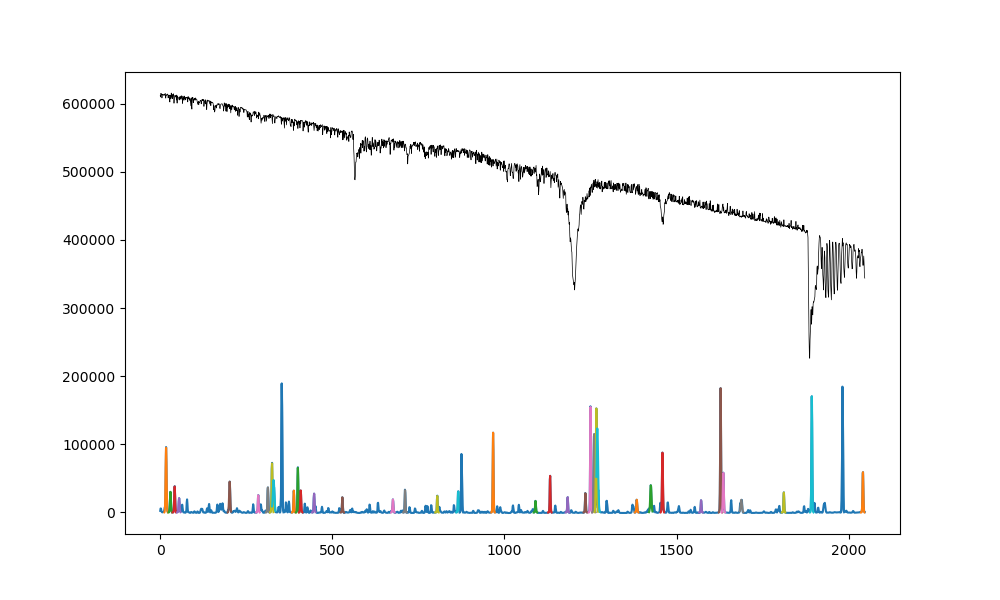

In [9]:
# fit each line w/ a gaussian model to retrieve the central pixel and fwhm
## overplot the RV std spectrum for reference
wcal_amp = []
wcal_x = []
wcal_std = []
plt.figure(figsize=(10,6))
plt.plot(rvstd_f_s1d*5.e5/np.mean(rvstd_f_s1d), c='k', lw=0.5)
plt.plot(mwcal_f_s1d.flux)
for l in lines:
    sub_region = SpectralRegion((l['line_center_index']-4)*u.pix, (l['line_center_index']+4)*u.pix)
    sub_spectrum = extract_region(mwcal_f_s1d, sub_region)
    g = spf.estimate_line_parameters(sub_spectrum, models.Gaussian1D())
    wcal_amp.append(g.amplitude.value)
    wcal_x.append(g.mean.value)
    wcal_std.append(g.stddev.value)
    xx = np.linspace((l['line_center_index']-5)*u.pix,(l['line_center_index']+5)*u.pix,22)
    plt.plot(xx, g(xx))
plt.show()

In [10]:
# associate two observed lines to tabulated ThAr lines and compute preliminary solution
wcal_lam = -1. * np.ones_like(wcal_x)
wcal_lam[6] = 6151.99 # Ar
wcal_lam[17] = 6342.86 # Ar
# linear solution lam = a*x + b
a = (wcal_lam[6] - wcal_lam[17]) / (wcal_x[6] - wcal_x[17])
b = wcal_lam[17] - a*wcal_x[17]
print('a = ', a*u.AA, ' ; b = ', b*u.AA)
lam0 = a*mwcal_f_s1d.spectral_axis.value + b

a =  0.38778863831620713 Angstrom  ; b =  6030.696469579546 Angstrom


<IPython.core.display.Javascript object>


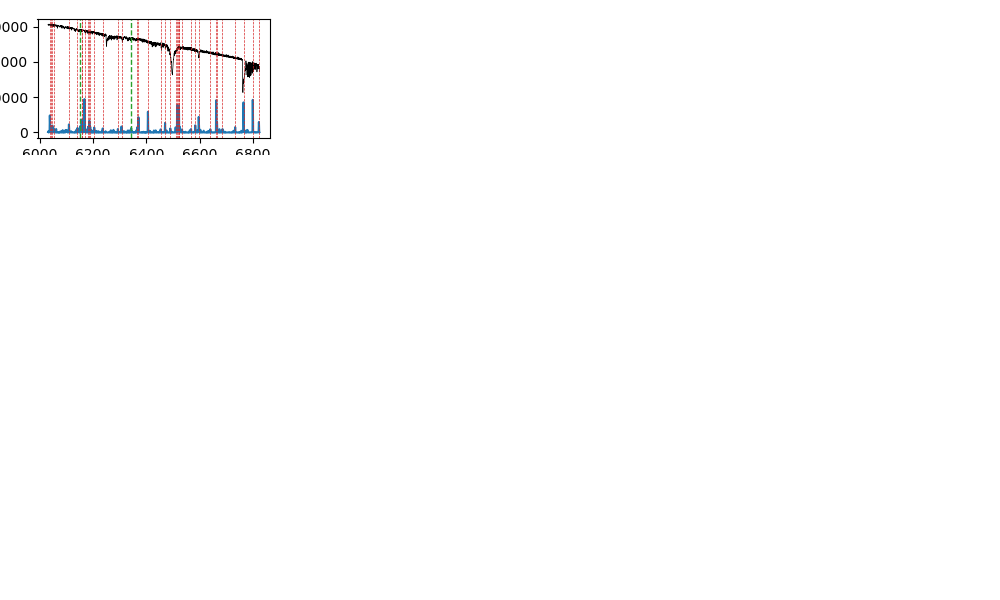

In [11]:
# Re-plot spectrum w/ this first solution and identify other lines
plt.figure(figsize=(10,6))
plt.plot(lam0, rvstd_f_s1d*5.e5/np.mean(rvstd_f_s1d), c='k', lw=0.5)
plt.plot(lam0, mwcal_f_s1d.flux)
for i, x in enumerate(wcal_x):
    if wcal_lam[i] > 1.:
        plt.axvline(a*x+b, ls='--', c='tab:green', lw=1.)
    elif wcal_lam[i] < 0.:
        plt.axvline(a*x+b, ls='--', c='tab:red', lw=0.5)
    else:
        plt.axvline(a*x+b, ls='--', c='grey', lw=0.5)

plt.show()

In [12]:
# identify more lines
# iterate from here until all useful lines are identified
wcal_lam = -1. * np.ones_like(wcal_x)
#wcal_lam[0] = 
wcal_lam[1] = 6037.70
wcal_lam[2] = 6043.23
#wcal_lam[3] = 
#wcal_lam[4] = 6059.37
#wcal_lam[4] = 6114.92
wcal_lam[5] = 6151.99
#wcal_lam[6] = 
wcal_lam[7] = 6169.82
#wcal_lam[8] =
wcal_lam[9] = 6182.62
#wcal_lam[10] = 
wcal_lam[11] = 6203.49
#wcal_lam[12] = 
#wcal_lam[13] = 6224.50
wcal_lam[14] = 6261.41
#wcal_lam[15] = 6327.28
wcal_lam[16] = 6342.86
wcal_lam[17] = 6384.72
#wcal_lam[18] = 6411.90
wcal_lam[19] = 6416.32
wcal_lam[20] = 6457.28
wcal_lam[21] = 6512.36
wcal_lam[22] = 6531.34
wcal_lam[23] = 6554.16
wcal_lam[24] = 6577.28
#wcal_lam[25] = 
wcal_lam[26] = 6588.54
#wcal_lam[27] = 
#wcal_lam[28] = 
#wcal_lam[30] = 6643.72
#wcal_lam[31] = 6662.27
wcal_lam[32] = 6677.28
#wcal_lam[33] = 6727.46
wcal_lam[34] = 6752.83
#wcal_lam[34] = 
#wcal_lam[35] = 6766.61
#wcal_lam[36] = 6780.41
wcal_lam[37] = 6834.93
wcal_lam[38] = 6871.29
wcal_lam[39] = 6911.23
#wcal_lam[40] = 6965.00

[29.72595519559349, 41.97745271083607, 284.8797374052286, 324.9063486023302, 353.25451577063217, 399.91634503708053, 529.2279674674561, 711.4281185920086, 804.9836936323853, 875.529357264133, 967.199281704891, 1090.4332574507334, 1132.7928177041194, 1183.7442804990542, 1235.4013902316838, 1260.7180286570901, 1459.1651099967507, 1628.2226532555064, 1811.8866215569485, 1893.1928256564402, 1982.5599024057606] [6037.7, 6043.23, 6151.99, 6169.82, 6182.62, 6203.49, 6261.41, 6342.86, 6384.72, 6416.32, 6457.28, 6512.36, 6531.34, 6554.16, 6577.28, 6588.54, 6677.28, 6752.83, 6834.93, 6871.29, 6911.23]


<IPython.core.display.Javascript object>


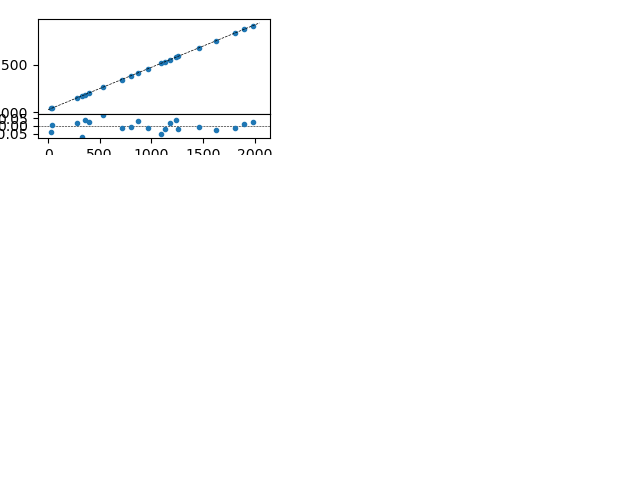

RMS = 0.0328 pix (nlines=21/ndf=18)


In [13]:
# create lists w/ only lines to fit
x_fit = [x for x,l in zip(wcal_x, wcal_lam) if l > 1.]
lam_fit = [l for l in wcal_lam if l > 1.]
print(x_fit, lam_fit)
# polynomial fit for wavelength solution
deg_wcal = 2 # set degree of wavelength calibration polynomial
wcal_coeff = np.polyfit(x_fit, lam_fit, deg=deg_wcal)
lam1 = np.poly1d(wcal_coeff)(mwcal_f_s1d.spectral_axis.value)
# plot fit and residual
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=0)
# main plot
ax1.plot(x_fit, lam_fit, marker='o', ms=3., color='tab:blue', ls='')
ax1.plot(mwcal_f_s1d.spectral_axis.value, lam1, c='k', ls='--', lw=0.5)
# residual 'O-C'
res = lam_fit - np.poly1d(wcal_coeff)(x_fit)
ax2.axhline(0., ls='--', c='k', lw=0.4)
ax2.plot(x_fit, res, 'o', c='tab:blue', ms=3.)
#ax2.set_xlim(0,1.e3)
#plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()
# Compute and print RMS
rms = np.sqrt(np.mean(res**2))
print("RMS = %.4f pix (nlines=%d/ndf=%d)" % (rms, len(x_fit), len(x_fit)-(deg_wcal+1)))

<IPython.core.display.Javascript object>


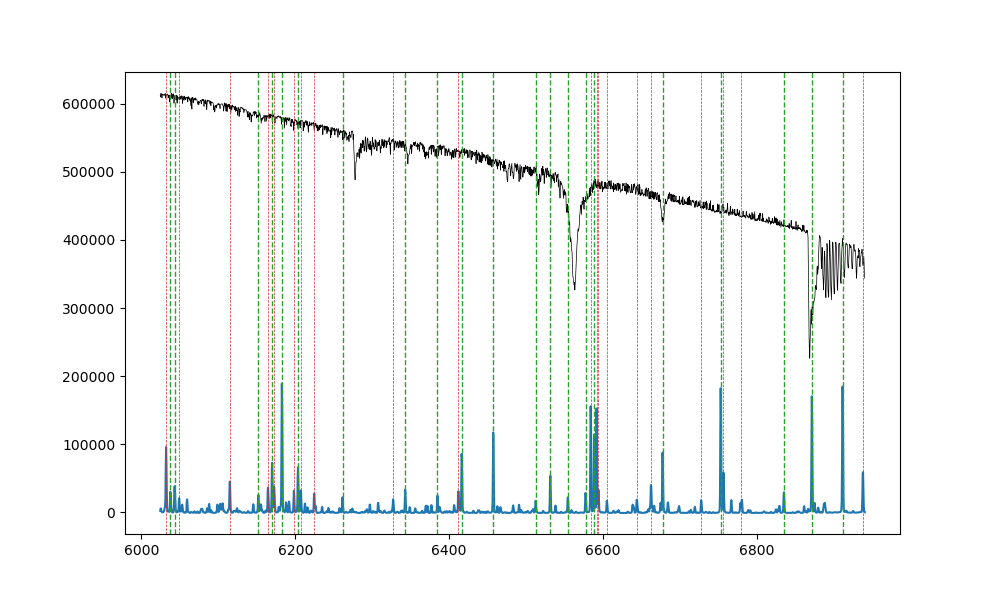

In [14]:
# Re-plot spectrum w/ this first solution and identify other lines
plt.figure(figsize=(10,6))
plt.plot(lam1, rvstd_f_s1d*5.e5/np.mean(rvstd_f_s1d), c='k', lw=0.5)
plt.plot(lam1, mwcal_f_s1d.flux)
for i, x in enumerate(wcal_x):
    if wcal_lam[i] > 1.:
        plt.axvline(np.poly1d(wcal_coeff)([x]), ls='--', c='tab:green', lw=1.)
    elif wcal_lam[i] < 0.:
        plt.axvline(np.poly1d(wcal_coeff)([x]), ls='--', c='tab:red', lw=0.5)
    else:
        plt.axvline(np.poly1d(wcal_coeff)([x]), ls='--', c='grey', lw=0.5)
#plt.xlim(3500., 8000.)
plt.show()

In [15]:
#Estimation résolution

R_list = [np.poly1d(wcal_coeff)(wcal_x[i])/(2*(np.poly1d(wcal_coeff)(wcal_std[i])-wcal_coeff[2])) for i in range(len(wcal_x))]
print(np.cumsum(R_list)[len(R_list)-1]/len(R_list))

5486.277870993929


## Apply redshift + combine spectrums

<IPython.core.display.Javascript object>


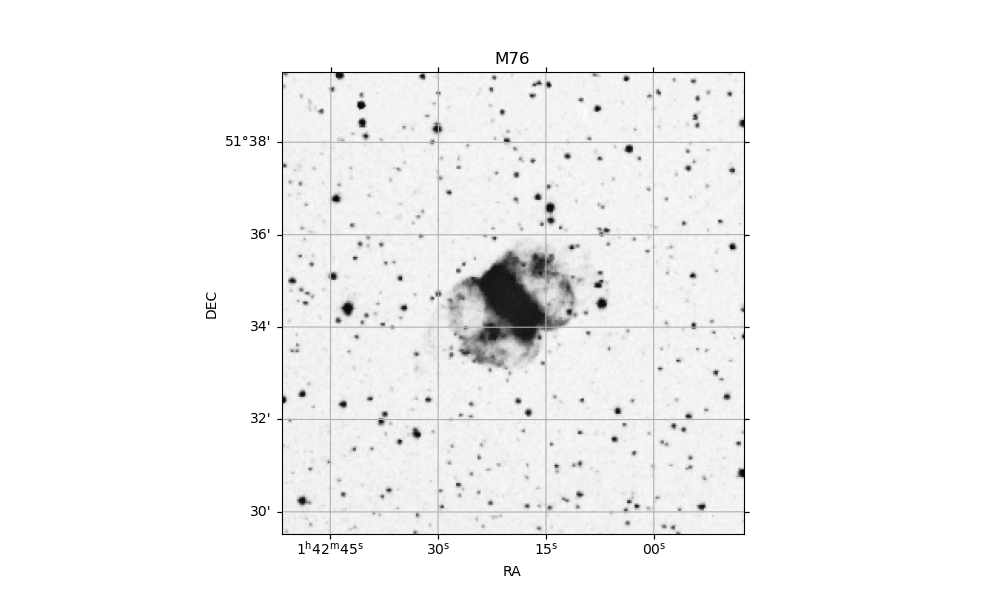

In [16]:
#Image de M76
plt.figure(figsize=(10,6))
M76 = FixedTarget.from_name('M76')
ax, hdu = plot_finder_image(M76)
plt.show()

<IPython.core.display.Javascript object>


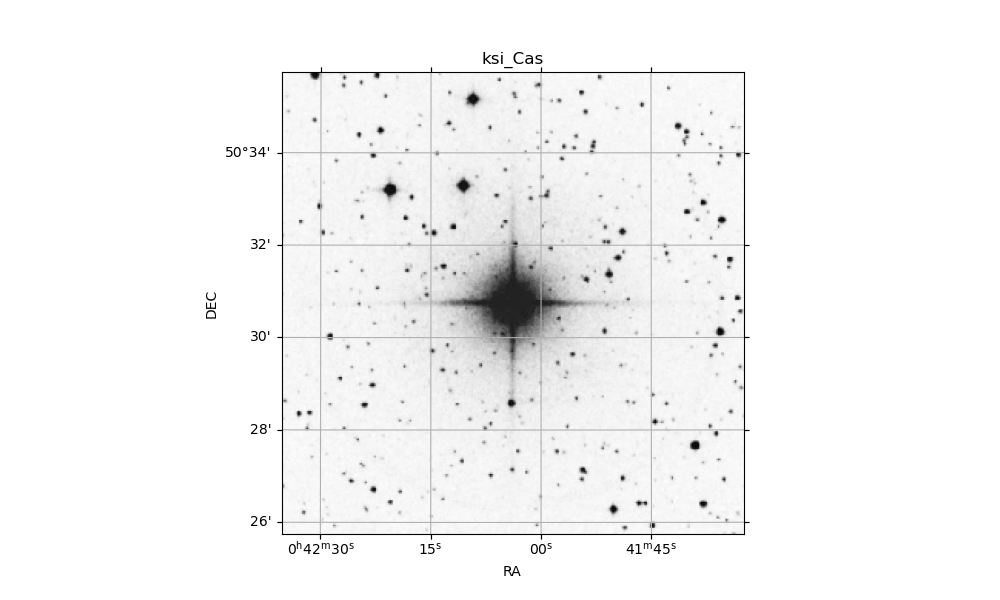

In [17]:
#Image de ksi_Cas
plt.figure(figsize=(10,6))
ksi_Cas = FixedTarget.from_name('ksi_Cas')
ax, hdu = plot_finder_image(ksi_Cas)
plt.show()

In [18]:
#Calcul du redshift

longitude = 5.712222 * u.deg
latitude = 43.931667 * u.deg
elevation = 650. * u.m
location = EarthLocation.from_geodetic(longitude, latitude, elevation)
observer = Observer(name='OHP',
                    location=location,
                    timezone=timezone('UTC'))

z_M76=[]
z_ksi_Cas=[]


time = Time(rvstd_s1d.header['date'])
z_ksi_Cas.append(ksi_Cas.coord.radial_velocity_correction(kind='barycentric', obstime=time, location=location).to(u.km/u.s))#/(3.e5 * u.km/u.s))
print("Le redshift associé à Ksi_Cas est : "+str(z_ksi_Cas))
print('\n')


time = Time(sci_s1d.header['date'])
z_M76.append(M76.coord.radial_velocity_correction(kind='barycentric', obstime=time, location=location).to(u.km/u.s))#/(3.e5 * u.km/u.s))
print("Le redshift associé à M76 est : "+str(z_M76))


Le redshift associé à Ksi_Cas est : [<Quantity 12.65513569 km / s>]


Le redshift associé à M76 est : [<Quantity 16.88153812 km / s>]


## Apply wavelength calibration to science and RV standard spectra + save to FITS

In [19]:
# Save science spectrum as a fits file
## primary HDU contains header from parent file
prihdu_sci_fw = pf.PrimaryHDU(header=sci_s1d.meta)
# extension HDU contains data stored as astropy.table.QTable
sci_fw_tab = QTable([lam1[::-1]*u.AA, sci_f_s1d.data[::-1]*u.electron, sig_sci_f_s1d.array[::-1]*u.electron], names=('wavelength', 'flux', 'uncertainty'))
sci_fw_hdu = pf.table_to_hdu(sci_fw_tab)
sci_hdul = pf.HDUList([prihdu_sci_fw, sci_fw_hdu])
bname, ext = os.path.splitext(fname_sci)
fname_sci_fw = bname.rstrip('_s1d') + '_fw_s1d' + ext
sci_hdul.writeto('reduced/'+fname_sci_fw, overwrite=True)
print(fname_sci_fw, 'saved')
## alternatively one can just save the QTable but original header info is lost
#sci_fw_tab.write('reduced/'+fname_sci_fw, overwrite=True)

# Save RV standard spectrum as a fits file
## primary HDU contains header from parent file
prihdu_rvstd_fw = pf.PrimaryHDU(header=rvstd_s1d.meta)
# extension HDU contains data stored as astropy.table.QTable
rvstd_fw_tab = QTable([lam1[::-1]*u.AA, rvstd_f_s1d.data[::-1]*u.electron, sig_rvstd_f_s1d.array[::-1]*u.electron], names=('wavelength', 'flux', 'uncertainty'))
rvstd_fw_hdu = pf.table_to_hdu(rvstd_fw_tab)
rvstd_hdul = pf.HDUList([prihdu_rvstd_fw, rvstd_fw_hdu])
bname, ext = os.path.splitext(fname_rvstd)
fname_rvstd_fw = bname.rstrip('_s1d') + '_fw_s1d' + ext
rvstd_hdul.writeto('reduced/'+fname_rvstd_fw, overwrite=True)
print(fname_rvstd_fw, 'saved')
## alternatively one can just save the QTable but original header info is lost
#sci_fw_tab.write('reduced/'+fname_rvstd_fw, overwrite=True)

PermissionError: [WinError 32] Le processus ne peut pas accéder au fichier car ce fichier est utilisé par un autre processus: 'reduced/Master_M76_fw_s1d.fit'

<IPython.core.display.Javascript object>


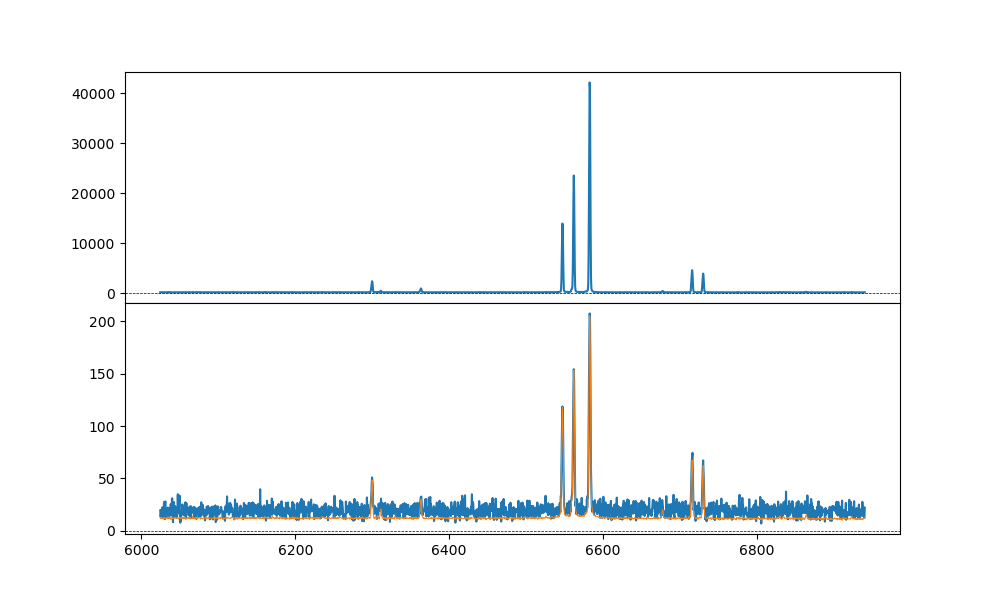

In [21]:
# Plot the spectrum and its uncertainty
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(hspace=0)
# science spectrum
ax1.plot(sci_fw_tab['wavelength'], sci_fw_tab['flux'])
ax1.axhline(0., ls='--', c='k', lw=.5)
# associated uncertainty'
ax2.plot(sci_fw_tab['wavelength'], sci_fw_tab['uncertainty'])
ax2.plot(sci_fw_tab['wavelength'], np.sqrt(sci_fw_tab['flux']), lw=0.7)
ax2.axhline(0., ls='--', c='k', lw=.5)
#ax2.set_xlim(0,1.e3)
plt.show()

In [22]:
# First method to load only binary table data
spec1d = QTable.read('reduced/'+fname_sci_fw)
print(spec1d)

    wavelength           flux           uncertainty    
     Angstrom                                          
----------------- ------------------ ------------------
6939.994892038888 151.20163099373738 22.216572810911014
6939.548136425777 165.61324303632958 12.300602380569325
6939.101380307257 152.58961605705383 13.074308654206158
6938.654623683328   146.669425461667 14.798258535482313
6938.207866553991 133.91189938725284  20.43820017533131
6937.761108919244 133.52021374107684 23.670442817563735
6937.314350779089 109.76796008184583  20.07485972215946
6936.867592133524  138.0919367086904 27.672301761728512
6936.420832982551 132.93162036520053 14.274406404897704
6935.974073326169  132.4621570032753 15.108692458821722
              ...                ...                ...
6028.457873597933 149.34745885515534  15.43139991307712
6028.010087961336 158.72454053308215 12.731127219182236
6027.562301819328 131.68346909680017 13.668129327954782
6027.114515171913 153.29942458519253 22.40533924

In [23]:
# Second method to retrieve metadata info as well
spec1d = pf.open('reduced/'+fname_sci_fw, ignore_missing_end=True)
print(spec1d.info())
print('\n')
print(spec1d[0].header)
print('\n')
print(spec1d[1].header)
print('\n')
print(type(spec1d[1]))

Filename: reduced/Master_M76_fw_s1d.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1                1 BinTableHDU     15   2048R x 3C   [D, D, D]   
None


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H HEAD    = 'DU940P_BV'          / Head model                                     ACQMODE = 'Single Scan'        / Acquisition mode                               READMODE= 'Image   '           / Readout mode                                   IMGRECT = '1, 2048, 512, 1'    / Image format       